<h1><center><font color = 'blue'>AMSUA N18 - Exploratory Data Analysis</font></center></h1>

In [1]:
import matplotlib.pyplot as plt
import lightgbm as lgbm
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats

### Import

In [2]:
df = pd.read_hdf('Data/amsua1200_n18_ch7.h5')

### Split inputs and outputs

In [3]:
X = df.drop(['CHANNEL', 'DATETIME', 'IMPACT', 'OBERR', 'OBTYPE', 'OMF',
             'PLATFORM', 'PRESSURE'], axis=1)

y = df['IMPACT']/df['OMF']

cols_2D = [col for col in X.columns if not any(char.isdigit() for char in col)]

### Explore y (sensitivity)

In [4]:
y.describe()

count    3.684330e+05
mean    -7.556022e-07
std      2.892440e-04
min     -6.330259e-03
25%     -8.867360e-05
50%     -1.282135e-06
75%      8.732254e-05
max      5.621825e-03
dtype: float64

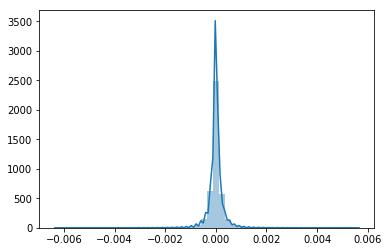

In [5]:
sns.distplot(y)

In [6]:
abs(y).describe()

count    3.684330e+05
mean     1.667401e-04
std      2.363479e-04
min      7.258921e-10
25%      3.550289e-05
50%      8.802591e-05
75%      2.010726e-04
max      6.330259e-03
dtype: float64

### y correlations with X variables 

In [7]:
y_corr = X.corrwith(y, axis=0)
print('\n5 largest corr with y:\n{}'.format(y_corr.nlargest()))
print('\n5 smallest corr with y:\n{}'.format(y_corr.nsmallest()))


5 largest corr with y:
ozone_390.897    0.018204
ozone_427.673    0.016601
qitot_265.745    0.016045
qitot_226.234    0.015647
qltot_776.243    0.015641
dtype: float64

5 smallest corr with y:
qitot_427.673   -0.016330
qitot_464.421   -0.016218
qltot_961.913   -0.010992
qltot_947.258   -0.010239
qitot_390.897   -0.010119
dtype: float64


### Train and predict (Linear Regression & Gradient Boosting)

In [8]:
# split train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [9]:
# train Linear Regression
lr = LinearRegression()
lr.fit(X_train[cols_2D], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
# train Gradient Boosting
gbm = lgbm.LGBMRegressor(objective='regression', n_estimators=300, learning_rate=0.1, random_state=10)

gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_names=('train', 'test'),
    eval_metric='l2',
    early_stopping_rounds=20,
    feature_name=X_train.columns.tolist(),
    verbose=False
)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=10,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [11]:
# predict LR
lr_pred = lr.predict(X_test[cols_2D])

In [12]:
# predict GBM
gbm_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

### Results

#### Linear Regression

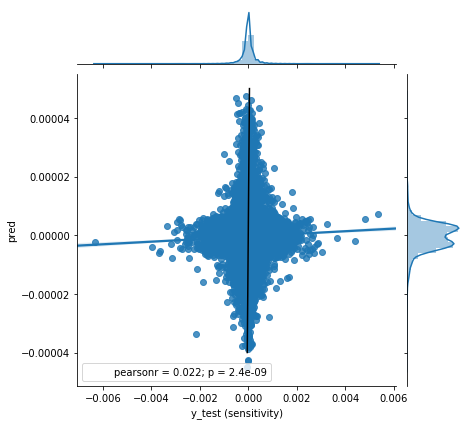

In [13]:
ax = sns.jointplot(x=y_test , y=lr_pred, kind="reg")
ax.annotate(stats.pearsonr)
ax.set_axis_labels(xlabel='y_test (sensitivity)', ylabel='pred')
# add bissectrice (in black)
plt.plot([-0.00004, 0.00005], [-0.00004, 0.00005], 'k-')
plt.show()

#### Gradient Boosting

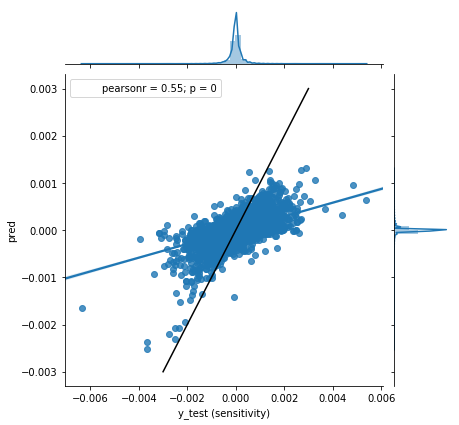

In [14]:
ax = sns.jointplot(x=y_test , y=gbm_pred, kind="reg")
ax.annotate(stats.pearsonr)
ax.set_axis_labels(xlabel='y_test (sensitivity)', ylabel='pred')
# add bissectrice (in black)
plt.plot([-0.003, 0.003], [-0.003, 0.003], 'k-')
plt.show()

#### Mean Squared Error

In [15]:
print('Only zeros MSE: {0:.11f}' .format(mean_squared_error(y_test, [0]*len(y_test))))
print('AMSUA LR MSE:   {0:.11f}' .format(mean_squared_error(y_test, lr_pred)))
print('AMSUA GBM MSE:  {0:.11f}' .format(mean_squared_error(y_test, gbm_pred)))

Only zeros MSE: 0.00000008267
AMSUA LR MSE:   0.00000008263
AMSUA GBM MSE:  0.00000006447
